In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 1

# Set up cashdir
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -v -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')


last updated: 2016-09-16 

CPython 3.5.2
IPython 5.1.0
Git hash: 5ddf692f5b628d6a70391d5b7ea35ae5e2b3e159


In [100]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('poster')

from sklearn import decomposition

pd.options.display.max_columns = 999

In [85]:
# Import metadata
metadata = pd.read_excel('../../data/jean/Metadata_Zhenxia_NLM_and_us.xlsx', skiprows=9, index_col=0)

metadata.columns = ['project_id',  'project_desc',  'pmid', 'publication_title',  'citation',  'blank1',
     'author_center_magic', 'sample_desc_magic',  'blank2', 'stage_magic',  'stage_details_magic', 
     'tissue_magic',  'tissue_type_magic', 'tissue_details_magic',  'system_magic',  'system_type_magic', 
     'system_details_magic', 'control_treatment_phenotype_magic',  'control_treatment_phenotype_details_magic',  'sex_magic',
     'blank3',  'sex_zhenxia',  'stage_zhenxia', 'tissue_zhenxia',  'genotype_zhenxia',  'cell_type_zhenxia', 'sample_type_zhenxia',  'center_name_zhenxia',  'blank4', 'stage_nlm',
     'cell_type_nlm', 'control_treatment_phenotype_nlm']

metadata.drop(['blank1', 'blank2', 'blank3', 'blank4'], inplace=True, axis=1)

In [23]:
# Import coverage counts
counts = pd.read_csv('../../data/zhenxia/htseq_merge_10755.txt', sep='\t', index_col=0)
counts = counts.T

In [24]:
# Import list of 312 golden and get goldent counts
golden = pd.read_csv('../../data/312_sample_golden_set_2016-06-14.txt', header=None)[0].tolist()

goldenCnts = counts[golden].copy()
goldenCnts.drop([x for x in goldenCnts.index if x.startswith('ERCC')], inplace=True)
goldenCnts.drop([x for x in goldenCnts.index if x.startswith('__')], inplace=True)
goldenCnts.drop(goldenCnts[(goldenCnts == 0).all(axis=1)].index, inplace=True)

# Calculate the correlation
goldenCorr = goldenCnts.corr(method='spearman')

In [92]:
# Create list of golden metadata
goldenMetadata = metadata.loc[golden, :]

In [217]:
# Set of class colors based on different columns from magic metadata
classes = goldenMetadata['author_center_magic'].unique()
cmap = {k: v for k, v in zip(classes, sns.color_palette("Paired", len(classes)))}
cmap[np.nan] = 'white'
center = goldenMetadata['author_center_magic'].map(cmap)

classes = goldenMetadata['stage_details_magic'].unique()
cmap = {k: v for k, v in zip(classes, sns.color_palette("Paired", len(classes)))}
cmap[np.nan] = 'white'
stage = goldenMetadata['stage_details_magic'].map(cmap)

classes = goldenMetadata['tissue_type_magic'].unique()
cmap = {k: v for k, v in zip(classes, sns.color_palette("Paired", len(classes)))}
cmap[np.nan] = 'white'
tissue = goldenMetadata['tissue_type_magic'].map(cmap)

classes = goldenMetadata['sex_magic'].unique()
cmap = {'Male': 'blue', 'Female': 'red', np.nan: 'white'}
sex = goldenMetadata['sex_magic'].map(cmap)

In [218]:
colors = pd.concat([center, stage, tissue, sex], axis=1)

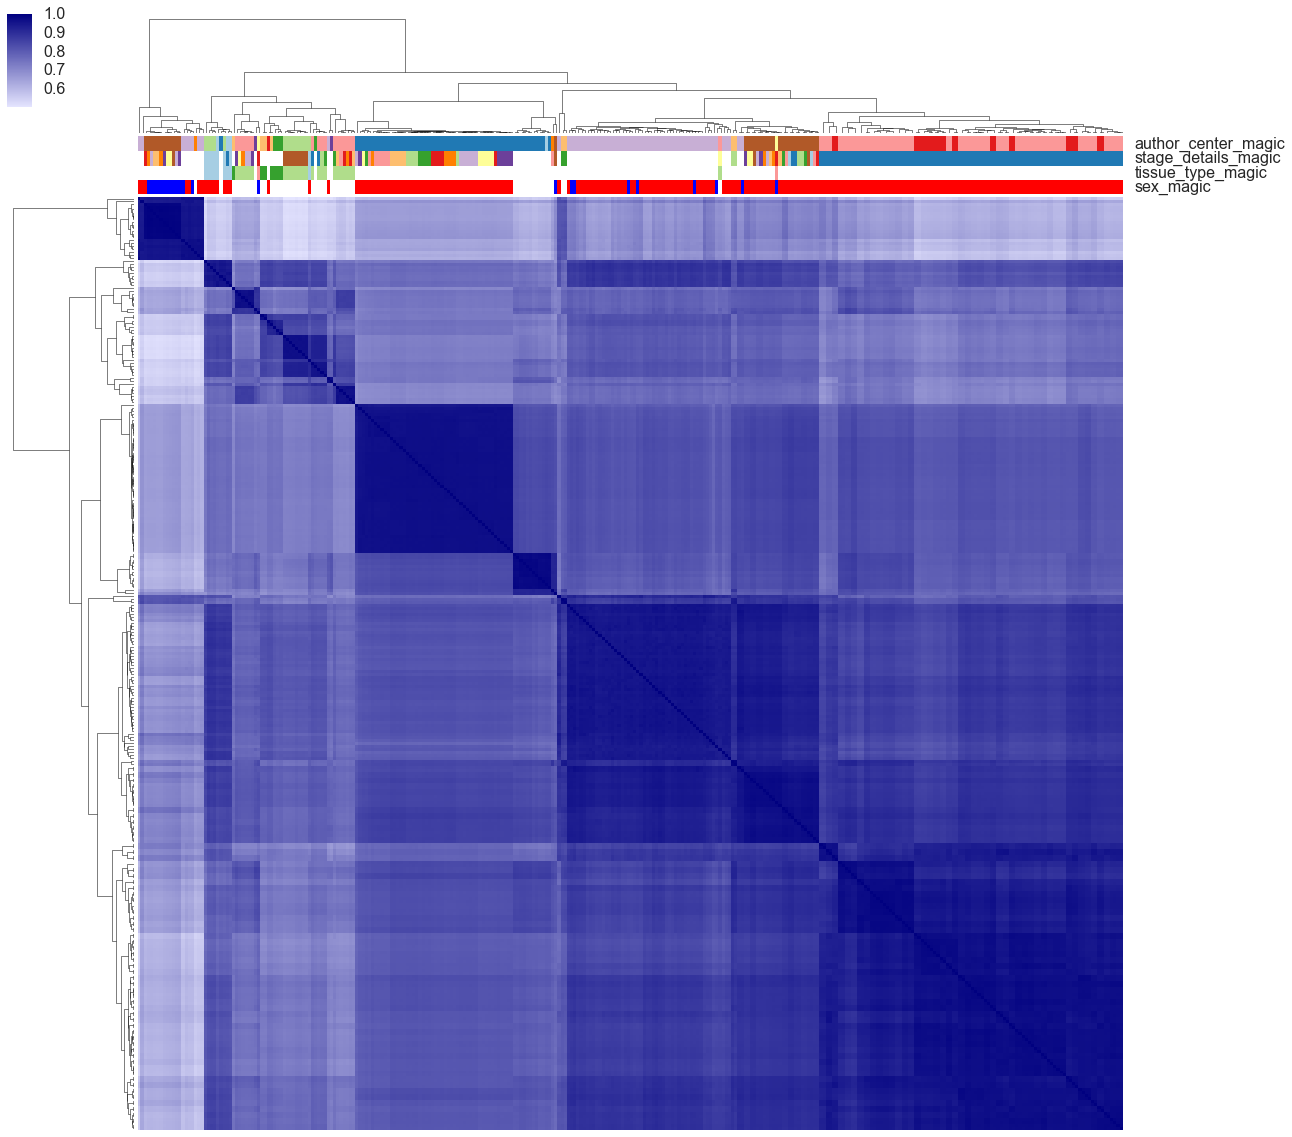

In [219]:
# Plot correlation of 
ax = sns.clustermap(goldenCorr, xticklabels=False, yticklabels=False, 
                    cmap=sns.light_palette("navy", as_cmap=True), row_cluster=True, 
                    col_cluster=True, col_colors=colors, figsize=(20, 20))

In [231]:
from scipy.cluster import vq, hierarchy
from scipy.spatial import distance

In [232]:
corr_array = np.asarray(goldenCorr)

In [233]:
row_linkage = hierarchy.linkage(distance.pdist(corr_array), method = 'average')
col_linkage = hierarchy.linkage(distance.pdist(corr_array.T), method = 'average')

In [239]:
row_linkage.shape

(311, 4)

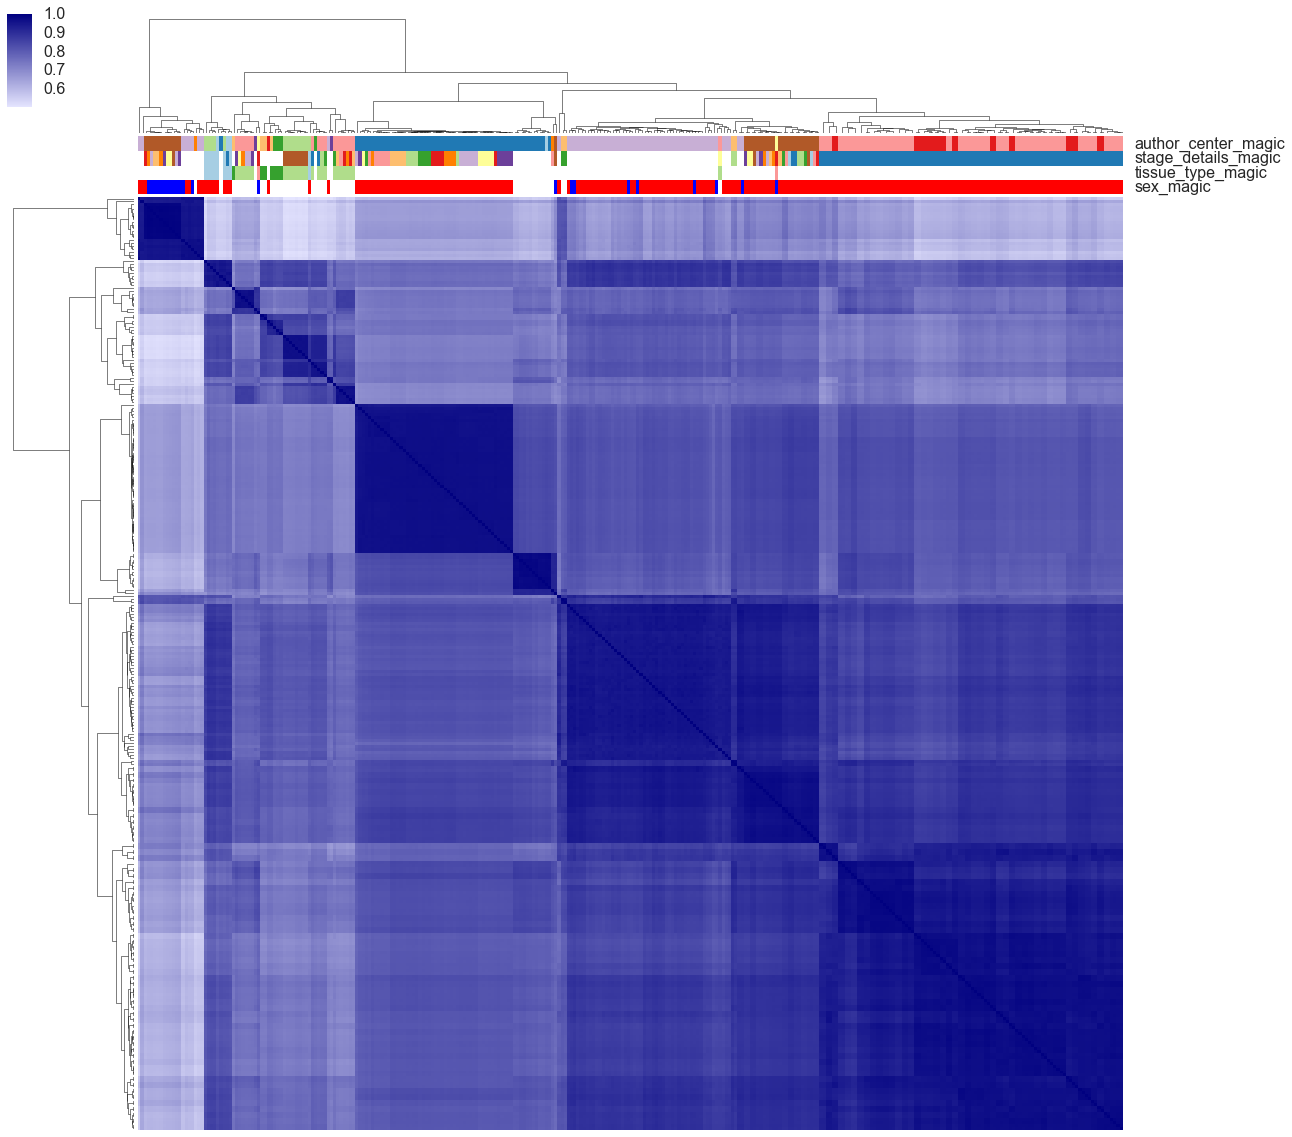

In [238]:
sns.clustermap(goldenCorr, row_linkage=row_linkage, col_linkage=col_linkage, xticklabels=False, yticklabels=False, 
                    cmap=sns.light_palette("navy", as_cmap=True), col_colors=colors, figsize=(20, 20))

In [242]:
from sklearn.cluster import k_means

In [292]:
kk = k_means(goldenCorr, 20)[1]
row_colors = pd.DataFrame(kk, index=goldenCorr.index, columns=['Kmeans (n=20)'])
row_colors = row_colors.applymap(lambda x: {k: v for k, v in zip(range(0, 20), sns.color_palette('cubehelix', 20))}[x])

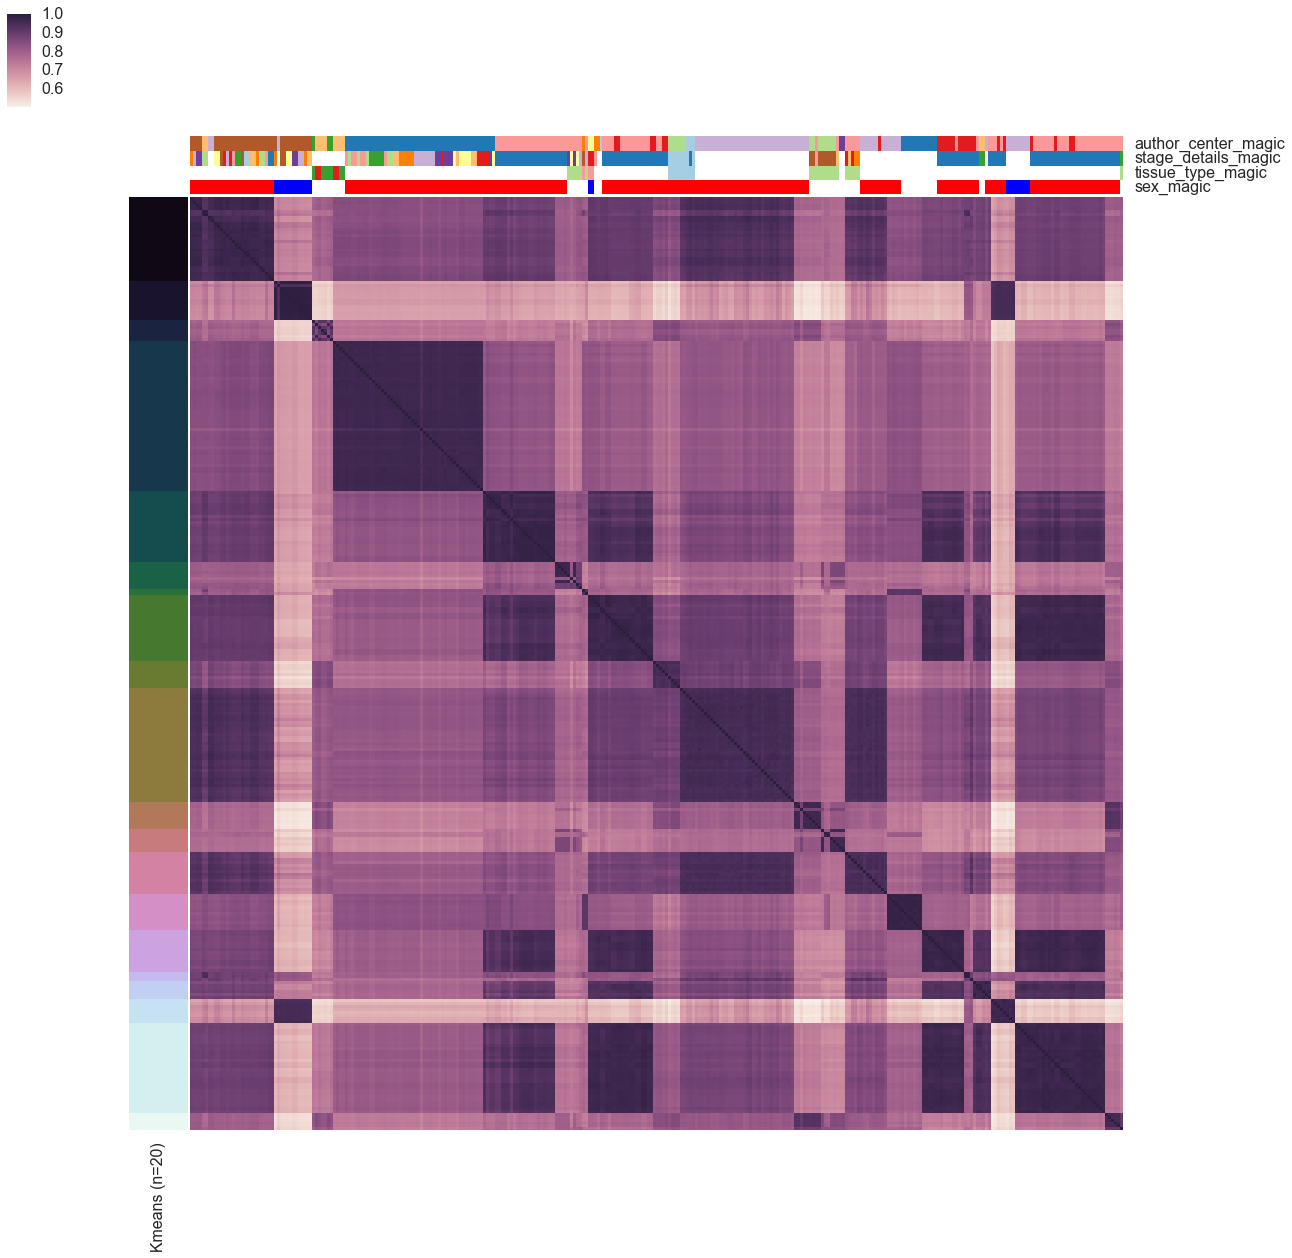

In [293]:
sns.clustermap(goldenCorr.iloc[kk.argsort(), kk.argsort()], row_cluster=False, col_cluster=False, col_colors=colors, row_colors=row_colors.iloc[kk.argsort()], yticklabels=False, xticklabels=False, figsize=(20, 20))